<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/Probabilty_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd /content/drive/MyDrive/Colab/pydomains/models/latest/

/content/drive/MyDrive/Colab/pydomains/models/latest


In [91]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

import joblib

In [ ]:
df = pd.read_csv('final.csv')

In [5]:
df.head()

,Unnamed: 0,site,actual,predicted,actual_labels,pred_labels,predicted_prob,adv,aggressive,alcohol,...,updatesites,urlshortener,violence,warez,weapons,webmail,webphone,webradio,webtv,scaled_probs
0,0,neptunesoccer,recreation,recreation,33,33,0.040239,0.018059,0.018040,0.018040,...,0.018040,0.018044,0.018040,0.018040,0.018048,0.018055,0.018040,0.018040,0.018040,0.755985
1,1,carena-girls,porn,recreation,31,33,0.027002,0.018218,0.018144,0.018174,...,0.018140,0.018175,0.018139,0.018156,0.018143,0.018237,0.018140,0.018173,0.018145,0.425040
2,2,natlhistoricseaport,recreation,gamble,33,14,0.022758,0.018316,0.018198,0.018306,...,0.018218,0.018243,0.018180,0.018228,0.018254,0.018275,0.018255,0.018183,0.018190,0.318959
3,3,gta-sanandreas,hobby,hobby,17,17,0.048474,0.017951,0.017951,0.017951,...,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.961859
4,4,radionaba,webradio,webradio,52,52,0.029569,0.018177,0.018120,0.018119,...,0.018122,0.018192,0.018119,0.018131,0.018119,0.018155,0.018119,0.029569,0.018148,0.489214


In [6]:
df = df.drop(['Unnamed: 0'], axis=1)

In [13]:
temp_df = df.copy()

In [14]:
temp_df['y'] = temp_df['actual'] == 'porn'

In [16]:
temp_df['y'] = temp_df['y'].astype(int)

In [17]:
temp_df.head()

,site,actual,predicted,actual_labels,pred_labels,predicted_prob,adv,aggressive,alcohol,anonvpn,...,urlshortener,violence,warez,weapons,webmail,webphone,webradio,webtv,scaled_probs,y
0,neptunesoccer,recreation,recreation,33,33,0.040239,0.018059,0.018040,0.018040,0.018040,...,0.018044,0.018040,0.018040,0.018048,0.018055,0.018040,0.018040,0.018040,0.755985,0
1,carena-girls,porn,recreation,31,33,0.027002,0.018218,0.018144,0.018174,0.018134,...,0.018175,0.018139,0.018156,0.018143,0.018237,0.018140,0.018173,0.018145,0.425040,1
2,natlhistoricseaport,recreation,gamble,33,14,0.022758,0.018316,0.018198,0.018306,0.018401,...,0.018243,0.018180,0.018228,0.018254,0.018275,0.018255,0.018183,0.018190,0.318959,0
3,gta-sanandreas,hobby,hobby,17,17,0.048474,0.017951,0.017951,0.017951,0.017951,...,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.961859,0
4,radionaba,webradio,webradio,52,52,0.029569,0.018177,0.018120,0.018119,0.018119,...,0.018192,0.018119,0.018131,0.018119,0.018155,0.018119,0.029569,0.018148,0.489214,0


In [27]:
def calibrate_data(label_name, p_df):
  temp_df = p_df.copy()
  temp_df['y'] = temp_df['actual'] == label_name
  temp_df['y'] = temp_df['y'].astype(int)
  X = temp_df[['adv', 'aggressive', 'alcohol', 'anonvpn',
       'automobile', 'costtraps', 'dating', 'downloads', 'drugs', 'dynamic',
       'education', 'finance', 'fortunetelling', 'forum', 'gamble',
       'government', 'hacking', 'hobby', 'homestyle', 'hospitals',
       'imagehosting', 'isp', 'jobsearch', 'library', 'military', 'models',
       'movies', 'music', 'news', 'podcasts', 'politics', 'porn', 'radiotv',
       'recreation', 'redirector', 'religion', 'remotecontrol', 'ringtones',
       'science', 'searchengines', 'sex', 'shopping', 'socialnet', 'spyware',
       'tracker', 'updatesites', 'urlshortener', 'violence', 'warez',
       'weapons', 'webmail', 'webphone', 'webradio', 'webtv']].to_numpy()
  y = temp_df['y'].to_numpy()
  return X, y

In [ ]:
def display_calibration_curve(X, y):
  X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, random_state=42)
  lr = LogisticRegression(C=1.0)
  gnb = GaussianNB()
  gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
  gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")
  clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
  ]
  fig = plt.figure(figsize=(10, 10))
  gs = GridSpec(4, 2)
  colors = plt.cm.get_cmap("Dark2")

  ax_calibration_curve = fig.add_subplot(gs[:2, :2])
  calibration_displays = {}
  for i, (clf, name) in enumerate(clf_list):
      clf.fit(X_train, y_train)
      display = CalibrationDisplay.from_estimator(
          clf,
          X_test,
          y_test,
          n_bins=10,
          name=name,
          ax=ax_calibration_curve,
          color=colors(i),
      )
      calibration_displays[name] = display

  ax_calibration_curve.grid()
  ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

  # Add histogram
  grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
  for i, (_, name) in enumerate(clf_list):
      row, col = grid_positions[i]
      ax = fig.add_subplot(gs[row, col])

      ax.hist(
          calibration_displays[name].y_prob,
          range=(0, 1),
          bins=10,
          label=name,
          color=colors(i),
      )
      ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

  plt.tight_layout()
  plt.show()

  scores = defaultdict(list)
  for i, (clf, name) in enumerate(clf_list):
      clf.fit(X_train, y_train)
      y_prob = clf.predict_proba(X_test)
      y_pred = clf.predict(X_test)
      scores["Classifier"].append(name)

      for metric in [brier_score_loss, log_loss]:
          score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
          scores[score_name].append(metric(y_test, y_prob[:, 1]))

      for metric in [precision_score, recall_score, f1_score, roc_auc_score]:
          score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
          scores[score_name].append(metric(y_test, y_pred))

      score_df = pd.DataFrame(scores).set_index("Classifier")
      score_df.round(decimals=3)
      print(score_df.to_string())

In [25]:
X, y = calibrate_data('porn', df)

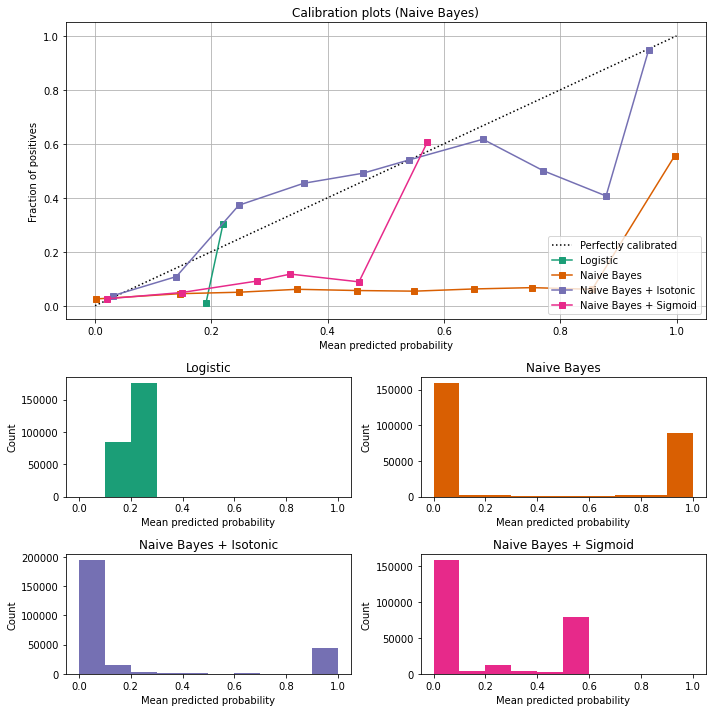

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Brier  loss  Log loss  Precision   Recall   F1   Roc auc 
Classifier                                                           
Logistic        0.14983  0.468712         0.0      0.0  0.0       0.5
             Brier  loss  Log loss  Precision    Recall        F1   Roc auc 
Classifier                                                                  
Logistic        0.149830  0.468712    0.000000  0.000000  0.000000  0.500000
Naive Bayes     0.179736  2.196084    0.524753  0.920192  0.668363  0.850759
                        Brier  loss  Log loss  Precision    Recall        F1   Roc auc 
Classifier                                                                             
Logistic                   0.149830  0.468712    0.000000  0.000000  0.000000  0.500000
Naive Bayes                0.179736  2.196084    0.524753  0.920192  0.668363  0.850759
Naive Bayes + Isotonic     0.046734  0.186331    0.931775  0.799403  0.860528  0.892022
                        Brier  loss  Log l

In [28]:
display_calibration_curve(X, y)

In [55]:
def train_save(X, y, label_name):
  gnb = GaussianNB()
  gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
  gnb_isotonic.fit(X, y)
  joblib.dump(gnb_isotonic, f"{label_name}.sav")

In [30]:
  gnb = GaussianNB()
  gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
  gnb_isotonic.fit(X, y)

CalibratedClassifierCV(base_estimator=GaussianNB(), cv=2, method='isotonic')

In [34]:
p_isotonic_prob = gnb_isotonic.predict_proba(X)

In [39]:
p_isotonic_prob

array([[0.90157874, 0.09842126],
       [0.60272219, 0.39727781],
       [0.97584885, 0.02415115],
       ...,
       [0.97540955, 0.02459045],
       [0.91225119, 0.08774881],
       [0.97540955, 0.02459045]])

In [41]:
p_isotonic_prob[:,1]

array([0.09842126, 0.39727781, 0.02415115, ..., 0.02459045, 0.08774881,
       0.02459045])

In [44]:
df['porn_i'] = p_isotonic_prob[:,1]

In [45]:
df.head()

,site,actual,predicted,actual_labels,pred_labels,predicted_prob,adv,aggressive,alcohol,anonvpn,...,urlshortener,violence,warez,weapons,webmail,webphone,webradio,webtv,scaled_probs,porn_i
0,neptunesoccer,recreation,recreation,33,33,0.040239,0.018059,0.018040,0.018040,0.018040,...,0.018044,0.018040,0.018040,0.018048,0.018055,0.018040,0.018040,0.018040,0.755985,0.098421
1,carena-girls,porn,recreation,31,33,0.027002,0.018218,0.018144,0.018174,0.018134,...,0.018175,0.018139,0.018156,0.018143,0.018237,0.018140,0.018173,0.018145,0.425040,0.397278
2,natlhistoricseaport,recreation,gamble,33,14,0.022758,0.018316,0.018198,0.018306,0.018401,...,0.018243,0.018180,0.018228,0.018254,0.018275,0.018255,0.018183,0.018190,0.318959,0.024151
3,gta-sanandreas,hobby,hobby,17,17,0.048474,0.017951,0.017951,0.017951,0.017951,...,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.961859,0.024151
4,radionaba,webradio,webradio,52,52,0.029569,0.018177,0.018120,0.018119,0.018119,...,0.018192,0.018119,0.018131,0.018119,0.018155,0.018119,0.029569,0.018148,0.489214,0.024151


In [47]:
p_df = df[['site','actual','predicted','predicted_prob','porn','porn_i']]

In [49]:
p_df

,site,actual,predicted,predicted_prob,porn,porn_i
0,neptunesoccer,recreation,recreation,0.040239,0.018275,0.098421
1,carena-girls,porn,recreation,0.027002,0.024312,0.397278
2,natlhistoricseaport,recreation,gamble,0.022758,0.018817,0.024151
3,gta-sanandreas,hobby,hobby,0.048474,0.017951,0.024151
4,radionaba,webradio,webradio,0.029569,0.018270,0.024151
...,...,...,...,...,...,...
263597,jades,porn,news,0.030875,0.018335,0.024590
263598,pornstrapon,porn,porn,0.046250,0.046250,0.943860
263599,awatunahomestead.co,recreation,recreation,0.048786,0.017947,0.024590
263600,sportsequip.co,shopping,shopping,0.038192,0.018050,0.087749


In [53]:
p_df[p_df['actual'] == 'porn']

,site,actual,predicted,predicted_prob,porn,porn_i
1,carena-girls,porn,recreation,0.027002,0.024312,0.397278
19,crazysex,porn,porn,0.039957,0.039957,0.943860
26,saharagetsdirty,porn,recreation,0.026341,0.019954,0.066704
32,247pantyhose,porn,porn,0.048601,0.048601,0.943860
37,erotikstart,porn,porn,0.048240,0.048240,0.943860
...,...,...,...,...,...,...
263584,usasextoy,porn,porn,0.048551,0.048551,0.943860
263586,viciosascaseras,porn,porn,0.047873,0.047873,0.943860
263588,garotavirtual.com,porn,porn,0.045933,0.045933,0.943860
263597,jades,porn,news,0.030875,0.018335,0.024590


In [56]:
train_save(X, y, 'porn')

In [57]:
%ls

final.csv  porn.sav  saved_model/  shallalist_v3_model.tar.gz


In [ ]:
def load_model(label_name):
  c_m = joblib.load(f"{label_name}.sav")
  c_m.predict_proba()

In [58]:
labels = ['adv', 'aggressive', 'alcohol', 'anonvpn',
       'automobile', 'costtraps', 'dating', 'downloads', 'drugs', 'dynamic',
       'education', 'finance', 'fortunetelling', 'forum', 'gamble',
       'government', 'hacking', 'hobby', 'homestyle', 'hospitals',
       'imagehosting', 'isp', 'jobsearch', 'library', 'military', 'models',
       'movies', 'music', 'news', 'podcasts', 'politics', 'porn', 'radiotv',
       'recreation', 'redirector', 'religion', 'remotecontrol', 'ringtones',
       'science', 'searchengines', 'sex', 'shopping', 'socialnet', 'spyware',
       'tracker', 'updatesites', 'urlshortener', 'violence', 'warez',
       'weapons', 'webmail', 'webphone', 'webradio', 'webtv']

In [59]:
for label in labels:
  X, y = calibrate_data(label, df)
  train_save(X, y, label)

In [60]:
label_model = {}

for label in labels:
  model = joblib.load(f"{label}.sav")
  label_model[label] = model

In [67]:
for label in labels:
  p_isotonic_prob = label_model[label].predict_proba(X)
  df[f'{label}_i'] = p_isotonic_prob[:,1]

In [69]:
df.head()

,site,actual,predicted,actual_labels,pred_labels,predicted_prob,adv,aggressive,alcohol,anonvpn,...,tracker_i,updatesites_i,urlshortener_i,violence_i,warez_i,weapons_i,webmail_i,webphone_i,webradio_i,webtv_i
0,neptunesoccer,recreation,recreation,33,33,0.040239,0.018059,0.018040,0.018040,0.018040,...,0.000036,0.000017,0.000154,0.000151,0.000097,0.000789,0.000221,0.000012,0.001052,0.000183
1,carena-girls,porn,recreation,31,33,0.027002,0.018218,0.018144,0.018174,0.018134,...,0.003930,0.000715,0.002192,0.000936,0.003046,0.000713,0.008923,0.000012,0.041425,0.001988
2,natlhistoricseaport,recreation,gamble,33,14,0.022758,0.018316,0.018198,0.018306,0.018401,...,0.000036,0.000017,0.000308,0.000027,0.000097,0.000080,0.000545,0.000511,0.000330,0.000036
3,gta-sanandreas,hobby,hobby,17,17,0.048474,0.017951,0.017951,0.017951,0.017951,...,0.000036,0.000017,0.000154,0.000027,0.000097,0.000080,0.000221,0.000012,0.000330,0.000036
4,radionaba,webradio,webradio,52,52,0.029569,0.018177,0.018120,0.018119,0.018119,...,0.000036,0.000017,0.002640,0.000027,0.000097,0.000080,0.000221,0.000012,0.041425,0.001988


In [76]:
common_cols = ['site', 'actual', 'predicted', 'predicted_prob']

In [79]:
uncalibrated = df[common_cols + labels]

In [80]:
uncalibrated.head()

,site,actual,predicted,predicted_prob,adv,aggressive,alcohol,anonvpn,automobile,costtraps,...,tracker,updatesites,urlshortener,violence,warez,weapons,webmail,webphone,webradio,webtv
0,neptunesoccer,recreation,recreation,0.040239,0.018059,0.018040,0.018040,0.018040,0.018056,0.018040,...,0.018042,0.018040,0.018044,0.018040,0.018040,0.018048,0.018055,0.018040,0.018040,0.018040
1,carena-girls,porn,recreation,0.027002,0.018218,0.018144,0.018174,0.018134,0.018154,0.018148,...,0.018156,0.018140,0.018175,0.018139,0.018156,0.018143,0.018237,0.018140,0.018173,0.018145
2,natlhistoricseaport,recreation,gamble,0.022758,0.018316,0.018198,0.018306,0.018401,0.018421,0.018204,...,0.018324,0.018218,0.018243,0.018180,0.018228,0.018254,0.018275,0.018255,0.018183,0.018190
3,gta-sanandreas,hobby,hobby,0.048474,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,...,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951,0.017951
4,radionaba,webradio,webradio,0.029569,0.018177,0.018120,0.018119,0.018119,0.018120,0.018120,...,0.018126,0.018122,0.018192,0.018119,0.018131,0.018119,0.018155,0.018119,0.029569,0.018148


In [81]:
isotinic_cols = [l+'_i' for l in labels]

In [84]:
calibrated = df[common_cols + isotinic_cols]

In [85]:
calibrated.head()

,site,actual,predicted,predicted_prob,adv_i,aggressive_i,alcohol_i,anonvpn_i,automobile_i,costtraps_i,...,tracker_i,updatesites_i,urlshortener_i,violence_i,warez_i,weapons_i,webmail_i,webphone_i,webradio_i,webtv_i
0,neptunesoccer,recreation,recreation,0.040239,0.000283,0.000145,0.001037,0.000012,0.003869,0.000035,...,0.000036,0.000017,0.000154,0.000151,0.000097,0.000789,0.000221,0.000012,0.001052,0.000183
1,carena-girls,porn,recreation,0.027002,0.017313,0.001530,0.008266,0.001437,0.004451,0.000536,...,0.003930,0.000715,0.002192,0.000936,0.003046,0.000713,0.008923,0.000012,0.041425,0.001988
2,natlhistoricseaport,recreation,gamble,0.022758,0.000352,0.000053,0.000097,0.000012,0.000330,0.000035,...,0.000036,0.000017,0.000308,0.000027,0.000097,0.000080,0.000545,0.000511,0.000330,0.000036
3,gta-sanandreas,hobby,hobby,0.048474,0.000283,0.000053,0.000097,0.000012,0.000330,0.000035,...,0.000036,0.000017,0.000154,0.000027,0.000097,0.000080,0.000221,0.000012,0.000330,0.000036
4,radionaba,webradio,webradio,0.029569,0.000283,0.000053,0.000097,0.000012,0.000330,0.000035,...,0.000036,0.000017,0.002640,0.000027,0.000097,0.000080,0.000221,0.000012,0.041425,0.001988


In [94]:
calibrated['predicted_prob'] = np.amax(calibrated[isotinic_cols].to_numpy(), axis=1)

<ipython-input-94-6acfe30f3a0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calibrated['predicted_prob'] = np.amax(calibrated[isotinic_cols].to_numpy(), axis=1)


In [96]:
calibrated

,site,actual,predicted,predicted_prob,adv_i,aggressive_i,alcohol_i,anonvpn_i,automobile_i,costtraps_i,...,tracker_i,updatesites_i,urlshortener_i,violence_i,warez_i,weapons_i,webmail_i,webphone_i,webradio_i,webtv_i
0,neptunesoccer,recreation,recreation,0.950654,0.000283,0.000145,0.001037,0.000012,0.003869,0.000035,...,0.000036,0.000017,0.000154,0.000151,0.000097,0.000789,0.000221,0.000012,0.001052,0.000183
1,carena-girls,porn,recreation,0.397278,0.017313,0.001530,0.008266,0.001437,0.004451,0.000536,...,0.003930,0.000715,0.002192,0.000936,0.003046,0.000713,0.008923,0.000012,0.041425,0.001988
2,natlhistoricseaport,recreation,gamble,0.049599,0.000352,0.000053,0.000097,0.000012,0.000330,0.000035,...,0.000036,0.000017,0.000308,0.000027,0.000097,0.000080,0.000545,0.000511,0.000330,0.000036
3,gta-sanandreas,hobby,hobby,0.712250,0.000283,0.000053,0.000097,0.000012,0.000330,0.000035,...,0.000036,0.000017,0.000154,0.000027,0.000097,0.000080,0.000221,0.000012,0.000330,0.000036
4,radionaba,webradio,webradio,0.665002,0.000283,0.000053,0.000097,0.000012,0.000330,0.000035,...,0.000036,0.000017,0.002640,0.000027,0.000097,0.000080,0.000221,0.000012,0.041425,0.001988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263597,jades,porn,news,0.665002,0.002993,0.000635,0.000680,0.000012,0.005396,0.000035,...,0.000244,0.000017,0.000358,0.000214,0.000338,0.000759,0.001165,0.000012,0.041425,0.001988
263598,pornstrapon,porn,porn,0.943860,0.000283,0.000053,0.000097,0.000012,0.000330,0.000035,...,0.000036,0.000017,0.000154,0.000027,0.000097,0.000080,0.000221,0.000012,0.000330,0.000036
263599,awatunahomestead.co,recreation,recreation,0.950654,0.000283,0.000053,0.000097,0.000012,0.000330,0.000035,...,0.000036,0.000017,0.000154,0.000027,0.000097,0.000086,0.000221,0.000012,0.000330,0.000036
263600,sportsequip.co,shopping,shopping,0.870093,0.000358,0.000145,0.001108,0.000012,0.020123,0.000035,...,0.000036,0.000017,0.000154,0.000151,0.000097,0.003272,0.000221,0.000012,0.000331,0.000036


In [97]:
calibrated.to_csv('calibrated.csv')

In [98]:
uncalibrated.to_csv('uncalibrated.csv')